In [22]:
import numpy as np
def rdnumpy(txtname):
    f = open(txtname)
    line = f.readlines()
    lines = len(line)  # row number
    for l in line:
        le = l.strip('\n').split(',')
        columns = len(le)-1  # col
        #print(le)
        #print(columns)
 
    A = np.zeros((lines, columns+1), dtype=np.single)
    print("read lines:",lines)
    print("read columns:",columns+1)
    A_row = 0
    for lin in line:
        #print(A_row)
        list = lin.strip('\n').split(',')
        A[A_row:] = list[0:columns+1]
        A_row += 1
    return A

In [23]:
#### Train &Test: 3360+1440

# Model

In [24]:
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import ToTensor, ToPILImage, Lambda
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [25]:
n_epochs = 3
batch_size_train = 6 #32,或者16-由於數據集比較小
batch_size_test = 1440*3
learning_rate = 0.001 #0.0001
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

# test

In [26]:
TrainDataf1=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat16\MTrainGf1.txt"))
TrainDataw0=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat16\MTrainGw0.txt"))
TrainDatam3=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat16\MTrainGm3.txt"))

read lines: 3360
read columns: 9
read lines: 3360
read columns: 9
read lines: 3360
read columns: 9


In [27]:
i=1        
startRow=i*8;
enRow=(i+1)*8;
TrainDataf1[startRow:enRow,1:9]


tensor([[  1.0000,   0.8131,   2.9704,   0.9205,   0.5750,   0.8272, 163.3465,
          15.0000],
        [  2.0000,   0.9322,   0.0000,   0.9341,   0.6881,   0.8870,  72.4430,
          15.0000],
        [  3.0000,   0.9849,   3.2958,   0.9161,   0.7802,   0.7873, 123.8874,
          15.0000],
        [  4.0000,   1.0643,   2.5331,   0.9470,   0.7682,   0.8969,  19.1108,
          15.0000],
        [  5.0000,   0.6967,   2.5257,   0.9227,   0.5341,   0.8969,  34.8293,
          15.0000],
        [  6.0000,   0.6874,   2.6791,   0.9211,   0.5331,   0.8670, -32.2424,
          15.0000],
        [  7.0000,   0.9041,   3.5410,   0.9231,   0.7001,   0.8969,  67.7012,
          15.0000],
        [  8.0000,   0.9196,   4.0943,   0.9317,   0.7423,   0.8471,  93.2369,
          15.0000]])

In [28]:
class ScottTrainDataset(Dataset):
    def __init__(self, transform=None, target_transform=None):
        TrainDataf1=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat16\MTrainGf1.txt"))
        TrainDataw0=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat16\MTrainGw0.txt"))
        TrainDatam3=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat16\MTrainGm3.txt"))
        #TrainDataq4=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat16\MTrainGq4.txt"))
        
        self.AllTrainData=torch.cat((TrainDataw0,TrainDataf1,TrainDatam3),0)
        # 定义transform
        self.transform = transform
        self.target_transform = target_transform
 
    def __len__(self):
        '''返回数据集中的样本数'''
        return 420*3
 
    def __getitem__(self, index):#需要第index個的數據
        '''获取数据的方法，会和Dataloader连用'''
        i=index;        
        startRow=i*8;
        enRow=(i+1)*8;
        nowData=self.AllTrainData[startRow:enRow,2:7]
        
        if index>=0 and index<420:
            nowLabel=1
        elif index>=420 and index<420*2:
            nowLabel=0
        elif index>=420*2 and index<420*3:
            nowLabel=2
            
        if self.transform:
            nowData = self.transform(nowData)
        if self.target_transform:
            nowLabel = self.target_transform(nowLabel)
        '''
        if nowLabel==0:
            nowLabel = torch.FloatTensor([1, 0])
        else:
            nowLabel = torch.FloatTensor([0, 1])
        '''
        return nowData, nowLabel#需要返回數據和標簽

In [29]:
class ScottTestDataset(Dataset):
    def __init__(self, transform=None, target_transform=None):
        TestDataf1=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat16\MTestGf1.txt"))
        TestDataw0=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat16\MTestGw0.txt"))
        TestDatam3=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat16\MTestGm3.txt"))
        #TestDataq4=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat16\MTestGq4.txt"))
        
        self.AllTrainData=torch.cat((TestDataw0,TestDataf1,TestDatam3),0)
        # 定义transform
        self.transform = transform
        self.target_transform = target_transform
 
    def __len__(self):
        '''返回数据集中的样本数'''
        return 180*3
 
    def __getitem__(self, index):#需要第index個的數據
        '''获取数据的方法，会和Dataloader连用'''
        i=index;        
        startRow=i*8;
        enRow=(i+1)*8;
        nowData=self.AllTrainData[startRow:enRow,2:7]
        
        if index>=0 and index<180:
            nowLabel=1
        elif index>=180 and index<180*2:
            nowLabel=0
        elif index>=180*2 and index<180*3:
            nowLabel=2
            
        if self.transform:
            nowData = self.transform(nowData)
        if self.target_transform:
            nowLabel = self.target_transform(nowLabel)
            
        '''
        if nowLabel==0:
            nowLabel = torch.FloatTensor([1, 0])
        else:
            nowLabel = torch.FloatTensor([0, 1])
        '''
            
        return nowData, nowLabel#需要返回數據和標簽

In [30]:
train_loader = torch.utils.data.DataLoader(ScottTrainDataset(),
    batch_size=batch_size_train, shuffle=True)


test_loader = torch.utils.data.DataLoader(ScottTestDataset(),
    batch_size=batch_size_test, shuffle=True)

read lines: 3360
read columns: 9
read lines: 3360
read columns: 9
read lines: 3360
read columns: 9
read lines: 1440
read columns: 9
read lines: 1440
read columns: 9
read lines: 1440
read columns: 9


# Network

In [31]:
#https://zhuanlan.zhihu.com/p/199624393
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=2, padding=1)
        self.conv2 = nn.Conv2d(10,20, kernel_size=3, padding=1)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(40, 15)
        self.fc2 = nn.Linear(15, 3)
    def forward(self, x):
        ##print(x)##
        #print("begin")
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print("relu1:")
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        #print("relu2:")
        #print(x.shape)
        x = x.view(-1,40)
        #print("view:")
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print("relu3:")
        #print(x.shape)
        x = F.dropout(x, training=self.training) 
        #print("dropout")
        #print(x.shape)
        x = self.fc2(x)
        #print("fc2")
        #print(x.shape)
        return F.log_softmax(x, dim=-1)
network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [32]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

# Train

In [33]:
#for batch_idx, (data, target) in enumerate(train_loader):
        #print(data.shape)
        #print(data)

In [34]:
train_losses = []
train_counter = []

def train(epoch):
  for _ in range(epoch):
      network.train()
      for batch_idx, (data, target) in enumerate(train_loader):
        #if batch_idx>1920 and batch_idx<1920+320: continue
        optimizer.zero_grad()
        data = data.unsqueeze(1)
        #print(data.shape)
        #print(data)
        output = network(data)
        #print(target.shape, target, output)
        #assert 1==0
        #loss = F.binary_cross_entropy_with_logits(output, target)
        ##
        #print("output:")
        #print(output)
        #print("target:")
        #print(target)
        #print(target.shape)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        '''
        print(torch.isnan(data).sum(), (target==1).sum()+(target==0).sum())
        assert (target==1).sum()+(target==0).sum()==16
        print(torch.isnan(data).sum(), target.shape, target, output)
        if torch.isnan(output).sum()!=0:
            print(data, target, torch.isnan(data).sum())
            print(data[-5])
        assert torch.isnan(output).sum()==0
        assert torch.isnan(loss).sum()==0
        '''
        if batch_idx % log_interval == 0:
          #print(torch.isnan(data).sum(), target.shape, target, output)
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            _ , batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
          train_losses.append(loss.item())
          train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
          torch.save(network.state_dict(), './model.pth')
          torch.save(optimizer.state_dict(), './optimizer.pth')
          #print(network.state_dict())
    
train(50)

Train Epoch: 0 [0/1260 (0%)]	Loss: 1.122275
Train Epoch: 0 [60/1260 (5%)]	Loss: 1.158016
Train Epoch: 0 [120/1260 (10%)]	Loss: 1.090868
Train Epoch: 0 [180/1260 (14%)]	Loss: 1.088864
Train Epoch: 0 [240/1260 (19%)]	Loss: 1.056840
Train Epoch: 0 [300/1260 (24%)]	Loss: 1.043243
Train Epoch: 0 [360/1260 (29%)]	Loss: 1.063275
Train Epoch: 0 [420/1260 (33%)]	Loss: 1.093406
Train Epoch: 0 [480/1260 (38%)]	Loss: 1.097387
Train Epoch: 0 [540/1260 (43%)]	Loss: 1.122840
Train Epoch: 0 [600/1260 (48%)]	Loss: 0.964924
Train Epoch: 0 [660/1260 (52%)]	Loss: 0.874288
Train Epoch: 0 [720/1260 (57%)]	Loss: 0.993755
Train Epoch: 0 [780/1260 (62%)]	Loss: 0.855600
Train Epoch: 0 [840/1260 (67%)]	Loss: 0.870679
Train Epoch: 0 [900/1260 (71%)]	Loss: 0.743034
Train Epoch: 0 [960/1260 (76%)]	Loss: 0.888663
Train Epoch: 0 [1020/1260 (81%)]	Loss: 0.594705
Train Epoch: 0 [1080/1260 (86%)]	Loss: 0.415151
Train Epoch: 0 [1140/1260 (90%)]	Loss: 0.647011
Train Epoch: 0 [1200/1260 (95%)]	Loss: 0.537370
Train Epoch: 1

Train Epoch: 8 [480/1260 (38%)]	Loss: 0.011901
Train Epoch: 8 [540/1260 (43%)]	Loss: 0.067697
Train Epoch: 8 [600/1260 (48%)]	Loss: 0.052804
Train Epoch: 8 [660/1260 (52%)]	Loss: 0.061860
Train Epoch: 8 [720/1260 (57%)]	Loss: 0.051507
Train Epoch: 8 [780/1260 (62%)]	Loss: 0.034486
Train Epoch: 8 [840/1260 (67%)]	Loss: 0.020740
Train Epoch: 8 [900/1260 (71%)]	Loss: 0.004404
Train Epoch: 8 [960/1260 (76%)]	Loss: 0.279770
Train Epoch: 8 [1020/1260 (81%)]	Loss: 0.104214
Train Epoch: 8 [1080/1260 (86%)]	Loss: 0.149504
Train Epoch: 8 [1140/1260 (90%)]	Loss: 0.031947
Train Epoch: 8 [1200/1260 (95%)]	Loss: 0.027383
Train Epoch: 9 [0/1260 (0%)]	Loss: 0.126200
Train Epoch: 9 [60/1260 (5%)]	Loss: 0.059853
Train Epoch: 9 [120/1260 (10%)]	Loss: 0.172425
Train Epoch: 9 [180/1260 (14%)]	Loss: 0.041522
Train Epoch: 9 [240/1260 (19%)]	Loss: 0.125602
Train Epoch: 9 [300/1260 (24%)]	Loss: 0.118679
Train Epoch: 9 [360/1260 (29%)]	Loss: 0.713278
Train Epoch: 9 [420/1260 (33%)]	Loss: 0.055788
Train Epoch: 9

Train Epoch: 16 [840/1260 (67%)]	Loss: 0.182816
Train Epoch: 16 [900/1260 (71%)]	Loss: 0.053308
Train Epoch: 16 [960/1260 (76%)]	Loss: 0.385874
Train Epoch: 16 [1020/1260 (81%)]	Loss: 0.143226
Train Epoch: 16 [1080/1260 (86%)]	Loss: 0.060731
Train Epoch: 16 [1140/1260 (90%)]	Loss: 0.017894
Train Epoch: 16 [1200/1260 (95%)]	Loss: 0.011530
Train Epoch: 17 [0/1260 (0%)]	Loss: 0.102894
Train Epoch: 17 [60/1260 (5%)]	Loss: 0.061735
Train Epoch: 17 [120/1260 (10%)]	Loss: 0.066093
Train Epoch: 17 [180/1260 (14%)]	Loss: 0.176914
Train Epoch: 17 [240/1260 (19%)]	Loss: 0.168955
Train Epoch: 17 [300/1260 (24%)]	Loss: 0.069392
Train Epoch: 17 [360/1260 (29%)]	Loss: 0.138797
Train Epoch: 17 [420/1260 (33%)]	Loss: 0.420479
Train Epoch: 17 [480/1260 (38%)]	Loss: 0.028861
Train Epoch: 17 [540/1260 (43%)]	Loss: 0.242127
Train Epoch: 17 [600/1260 (48%)]	Loss: 0.133227
Train Epoch: 17 [660/1260 (52%)]	Loss: 0.892315
Train Epoch: 17 [720/1260 (57%)]	Loss: 0.000159
Train Epoch: 17 [780/1260 (62%)]	Loss: 0.

Train Epoch: 24 [1140/1260 (90%)]	Loss: 0.230176
Train Epoch: 24 [1200/1260 (95%)]	Loss: 0.035809
Train Epoch: 25 [0/1260 (0%)]	Loss: 0.001223
Train Epoch: 25 [60/1260 (5%)]	Loss: 0.087840
Train Epoch: 25 [120/1260 (10%)]	Loss: 0.025675
Train Epoch: 25 [180/1260 (14%)]	Loss: 0.137832
Train Epoch: 25 [240/1260 (19%)]	Loss: 0.023726
Train Epoch: 25 [300/1260 (24%)]	Loss: 0.009102
Train Epoch: 25 [360/1260 (29%)]	Loss: 0.043618
Train Epoch: 25 [420/1260 (33%)]	Loss: 0.009566
Train Epoch: 25 [480/1260 (38%)]	Loss: 0.135072
Train Epoch: 25 [540/1260 (43%)]	Loss: 0.067311
Train Epoch: 25 [600/1260 (48%)]	Loss: 0.477784
Train Epoch: 25 [660/1260 (52%)]	Loss: 0.007204
Train Epoch: 25 [720/1260 (57%)]	Loss: 0.097527
Train Epoch: 25 [780/1260 (62%)]	Loss: 0.172374
Train Epoch: 25 [840/1260 (67%)]	Loss: 0.027187
Train Epoch: 25 [900/1260 (71%)]	Loss: 0.008379
Train Epoch: 25 [960/1260 (76%)]	Loss: 0.010957
Train Epoch: 25 [1020/1260 (81%)]	Loss: 0.056743
Train Epoch: 25 [1080/1260 (86%)]	Loss: 0.

Train Epoch: 33 [240/1260 (19%)]	Loss: 0.106687
Train Epoch: 33 [300/1260 (24%)]	Loss: 0.008764
Train Epoch: 33 [360/1260 (29%)]	Loss: 0.102158
Train Epoch: 33 [420/1260 (33%)]	Loss: 0.032151
Train Epoch: 33 [480/1260 (38%)]	Loss: 0.019819
Train Epoch: 33 [540/1260 (43%)]	Loss: 0.070271
Train Epoch: 33 [600/1260 (48%)]	Loss: 0.275331
Train Epoch: 33 [660/1260 (52%)]	Loss: 0.003307
Train Epoch: 33 [720/1260 (57%)]	Loss: 0.437035
Train Epoch: 33 [780/1260 (62%)]	Loss: 0.003069
Train Epoch: 33 [840/1260 (67%)]	Loss: 0.236615
Train Epoch: 33 [900/1260 (71%)]	Loss: 0.023477
Train Epoch: 33 [960/1260 (76%)]	Loss: 0.134432
Train Epoch: 33 [1020/1260 (81%)]	Loss: 0.000908
Train Epoch: 33 [1080/1260 (86%)]	Loss: 0.022406
Train Epoch: 33 [1140/1260 (90%)]	Loss: 0.731620
Train Epoch: 33 [1200/1260 (95%)]	Loss: 0.682431
Train Epoch: 34 [0/1260 (0%)]	Loss: 0.025213
Train Epoch: 34 [60/1260 (5%)]	Loss: 0.138239
Train Epoch: 34 [120/1260 (10%)]	Loss: 0.006342
Train Epoch: 34 [180/1260 (14%)]	Loss: 0.

Train Epoch: 41 [660/1260 (52%)]	Loss: 0.024270
Train Epoch: 41 [720/1260 (57%)]	Loss: 0.039304
Train Epoch: 41 [780/1260 (62%)]	Loss: 0.002498
Train Epoch: 41 [840/1260 (67%)]	Loss: 0.203193
Train Epoch: 41 [900/1260 (71%)]	Loss: 0.062432
Train Epoch: 41 [960/1260 (76%)]	Loss: 0.022744
Train Epoch: 41 [1020/1260 (81%)]	Loss: 0.383774
Train Epoch: 41 [1080/1260 (86%)]	Loss: 0.026715
Train Epoch: 41 [1140/1260 (90%)]	Loss: 0.003222
Train Epoch: 41 [1200/1260 (95%)]	Loss: 0.037290
Train Epoch: 42 [0/1260 (0%)]	Loss: 0.024132
Train Epoch: 42 [60/1260 (5%)]	Loss: 0.030067
Train Epoch: 42 [120/1260 (10%)]	Loss: 0.027559
Train Epoch: 42 [180/1260 (14%)]	Loss: 0.260456
Train Epoch: 42 [240/1260 (19%)]	Loss: 0.008011
Train Epoch: 42 [300/1260 (24%)]	Loss: 0.002362
Train Epoch: 42 [360/1260 (29%)]	Loss: 0.033148
Train Epoch: 42 [420/1260 (33%)]	Loss: 0.033600
Train Epoch: 42 [480/1260 (38%)]	Loss: 0.263585
Train Epoch: 42 [540/1260 (43%)]	Loss: 0.007883
Train Epoch: 42 [600/1260 (48%)]	Loss: 0.

Train Epoch: 49 [1200/1260 (95%)]	Loss: 0.076961


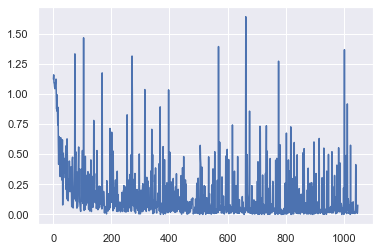

In [35]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt

plt.plot(list(range(len(train_losses))), train_losses)
plt.show()

In [36]:
'''
for p in network.parameters():
    print(p)
    break
tmp = torch.load('./model.pth')
network.load_state_dict(tmp)
for p in network.parameters():
    print(p)
    break
'''

"\nfor p in network.parameters():\n    print(p)\n    break\ntmp = torch.load('./model.pth')\nnetwork.load_state_dict(tmp)\nfor p in network.parameters():\n    print(p)\n    break\n"

In [37]:
import scipy.io as io
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.unsqueeze(1)
      #print("data:")
      #print(data.shape)
      output = network(data)
      #print("output:")
      #print(output.shape)
      
      test_loss += F.nll_loss(output, target, size_average=False).item()
      #print(output)
      pred = output.data.max(1, keepdim=True)[1]
      #print(pred)###
      result1 = np.array(pred)
      np.savetxt('pred.txt',result1)
      result2 = np.array(target)
      np.savetxt('target.txt',result2)
      
      #Save done
      correct += pred.eq(target.data.view_as(pred)).sum()
      
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    
test()


Test set: Avg. loss: 0.0243, Accuracy: 537/540 (99.44%)



C:\Users\PCI\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# confusion matrix

In [41]:
from sklearn.metrics import f1_score
 
y_true = target
y_pred = pred
 
print(f1_score(y_true, y_pred, average='weighted'))# unbalance F1
print(f1_score(y_true, y_pred, average='macro'))
print()
print(f1_score(y_true, y_pred, average=None))
print("Acute       Normal      Chronic")

0.9944444015771725
0.9944444015771726

[1.         0.99168975 0.99164345]
Acute       Normal      Chronic


[[100.     0.     0.  ]
 [  0.    99.44   0.56]
 [  0.     1.11  98.89]]


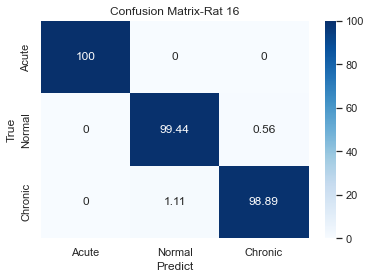

In [42]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

sns.set()
f,ax = plt.subplots()
y_true =(target)
y_pred = (pred)
C2 = confusion_matrix(y_true,y_pred,labels=[0,1,2])

fm=C2.sum(axis=1)
C3=C2/fm*100
C3=np.around(C3,decimals=2)

print(C3)
a=sns.heatmap(C3,annot=True,ax=ax, cmap = 'Blues', fmt='g') #画热力图  , cbar = None

ax.set_title('Confusion Matrix-Rat 16') #标题
ax.set_xlabel('Predict') #x 轴
ax.set_ylabel('True') #y 轴


#Normal, Acute, Chronic, Pre-seizure
a.set_xticklabels(['Acute','Normal','Chronic'])
a.set_yticklabels(['Acute','Normal','Chronic'])


fig = a.get_figure()
fig.savefig("6F_3C.png", dpi=1080)